<a href="https://colab.research.google.com/github/suhrobm/Machine-Learning-In-Industry/blob/main/Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **LAB 1. The frequency of publications in different urban areas**
---

### **Content** 🎯


You are presented with a dataset of one popular social network that includes more than 8.5 million records with meta-information of publications over 13 months (January 2019 to February 2020).

Using this data, you will need to predict the number of publications in each 250x250 meter polygon for each hour 4 weeks (28 days) ahead of the last publication in the training set.


**Notes**

*  The length of the data set allows considering both the seasonal factor of activity changes and the general trend of growth/decline in the number of publications.
*   It is worth paying attention to the fact that the time parameters of publications can have a strong influence on the activity.
*   The density of the number of publications may vary greatly from district to district.









# **About Dataset**

Each publication is described by the following meta-information:

---

**Context**


*   **lon, lat** -- geoposition coordinates rounded up to a 250x250 meter polygon (geographical longitude and latitude, respectively)
*   **timestamp** -- timestamp of the publication accurate to one hour
*   **likescount** -- number of "likes" in the publication
*   **commentscount** -- number of comments of the publication
*   **symbols_cnt** -- number of all symbols in the publication
*   **words_cnt** -- number of words (meaningful, not counting special characters and other meta-information)
*   **hashtags_cnt** -- number of hashtags
*   **mentions_cnt** -- the number of mentions of other users
*   **links_cnt** -- number of links
*   **emoji_cnt** -- number of emoji
*   **point** -- service field for matching coordinates from training, validation and test datasets (if two elements have the same point, they have the same coordinates, comparison of lat and lon may give an error)

**Content**

Using this data, you will need to predict the number of publications in each 250x250 meter polygon for each hour 4 weeks (28 days) ahead of the last publication in the training set.

The square with coordinates of two opposite corners (60.0393322852, 30.5360) and (59.828, 30.142969) can be considered as boundaries, it is guaranteed that in the test dataset the coordinates do not exceed these boundaries.


In [ ]:
!pip install eli5 xgboost statsmodels pmdarima

In [ ]:
!pip install -U notebook-as-pdf
!pyppeteer-install

In [ ]:
import datetime
import numpy as np
import pandas as pd
from datetime import date
from matplotlib import pyplot as plt
import seaborn as sns
import holidays
from sklearn.utils import resample, shuffle
import missingno as msno
import pickle
import eli5
import pmdarima
from sklearn.utils import shuffle
from statsmodels.tsa.arima.model import ARIMA
from eli5.sklearn import PermutationImportance
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lars
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score



import warnings

from google.colab import drive
drive.mount('/content/drive')

# prevents numpy scientific/exponential notation on print, default is False
# force-suppressing the scientific notation, it is rounded and justified
np.set_printoptions(suppress=False, formatter={'float_kind':'{:0.2f}'.format})
# ignoring warnings
warnings.filterwarnings(action='ignore')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. Data Preprocessing Procedure

Trying to find out:

Missing Values, Feature Engineering and Standardization

In [ ]:
''' Reading whole dataset from file and loading the data and save it in a DataFrame
'''
working_df = pd.read_csv('/content/drive/MyDrive/ITMO/MLIndustry/train_data.csv')
working_df.head(5)

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point
0,1565607600,30.329370,59.940488,63,4,52,6,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...
1,1565568000,30.342845,59.869542,44,0,40,0,4,0,0,0,0101000020E6100000544263A8C4573E40C27FCF284DEF...
2,1565568000,30.322632,60.039332,30,0,77,7,0,0,0,1,0101000020E61000009E01B90998523E40888919D70805...
3,1565568000,30.322632,59.938238,13,0,634,17,32,0,0,7,0101000020E61000009E01B90998523E40CEB8CE2B18F8...
4,1565568000,30.309158,59.932612,8,0,0,0,0,0,0,0,0101000020E6100000268147F5244F3E40494A4ED65FF7...


In [ ]:
''' Reading whole dataset from file and loading the data and save it in a DataFrame
'''
test_df = pd.read_csv('/content/drive/MyDrive/ITMO/MLIndustry/test.csv')
test_df.head(5)

,hour,lat,lon,point,sum,error
0,1582711200,59.934863,30.331616,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,7,0.370265
1,1581937200,59.940488,30.329370,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,6,0.754735
2,1581523200,59.905597,30.297929,0101000020E61000006AEBE80E454C3E407F614299EAF3...,5,3.754735
3,1581512400,59.921359,30.356319,0101000020E6100000CFC2D4BC375B3E401FBF4913EFF5...,16,4.088069
4,1581771600,59.939363,30.315895,0101000020E61000006141807FDE503E40A554BF083DF8...,10,2.088069


In [ ]:
''' Reading whole dataset from file and loading the data and save it in a DataFrame
'''
validation_df = pd.read_csv('/content/drive/MyDrive/ITMO/MLIndustry/validation_data.csv')
validation_df.head(5)

,hour,lat,lon,point,sum,error
0,1582448400,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,0.421402
1,1582225200,59.924735,30.241784,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,14,0.310291
2,1581260400,60.002300,30.295683,0101000020E6100000AB00D6E0B14B3E40CB88A75E4B00...,5,3.754735
3,1581958800,59.935988,30.324878,0101000020E61000005DECCB372B533E40E4A1F770CEF7...,7,0.504735
4,1582779600,59.933737,30.306912,0101000020E6100000669634C7914E3E407AB3D8B484F7...,14,1.554735


In [ ]:
''' info() helps us to see how many values are existing in each column and their data type. Here, we can
    see many columns have missing values which we need to fill with some sensible values. Handling missing
    data is important as many machine learning algorithms do not support data with missing values.
'''
working_df.info()
print(f'\n')
test_df.info()
print(f'\n')
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8526526 entries, 0 to 8526525
Data columns (total 12 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   lon            float64
 2   lat            float64
 3   likescount     int64  
 4   commentscount  int64  
 5   symbols_cnt    int64  
 6   words_cnt      int64  
 7   hashtags_cnt   int64  
 8   mentions_cnt   int64  
 9   links_cnt      int64  
 10  emoji_cnt      int64  
 11  point          object 
dtypes: float64(2), int64(9), object(1)
memory usage: 780.6+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   hour    700 non-null    int64  
 1   lat     700 non-null    float64
 2   lon     700 non-null    float64
 3   point   700 non-null    object 
 4   sum     700 non-null    int64  
 5   error   700 non-null    float64
dtypes: float64(3), int64(2),

In [ ]:
''' describe() is used to view some basic statistical details like percentile, mean, std, etc. of a DataFrame, i.e.
    getting some statictical inferences.
'''
working_df.describe()

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt
count,8.526526e+06,8.526526e+06,8.526526e+06,8.526526e+06,8.526526e+06,8.526526e+06,8.526526e+06,8.526526e+06,8.526526e+06,8.526526e+06,8.526526e+06
mean,1.564713e+09,3.005684e+01,5.941014e+01,1.073289e+02,4.281519e+00,2.935381e+02,2.227026e+01,4.969738e+00,2.337222e-01,1.596899e-02,3.001426e+00
std,9.472518e+06,2.851339e+00,5.582277e+00,3.120410e+03,6.927234e+01,4.169500e+02,3.842956e+01,8.166667e+00,9.078254e-01,1.590046e-01,5.725451e+00
min,1.546301e+09,-4.841021e+01,-1.390007e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.557061e+09,3.028221e+01,5.992136e+01,1.700000e+01,0.000000e+00,2.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.565474e+09,3.031590e+01,5.993486e+01,3.700000e+01,1.000000e+00,1.160000e+02,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.572638e+09,3.035632e+01,5.995961e+01,7.400000e+01,3.000000e+00,4.010000e+02,2.500000e+01,6.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
max,1.580512e+09,1.371368e+02,6.037409e+01,8.700346e+06,1.111460e+05,2.200000e+03,4.860000e+02,2.340000e+02,9.200000e+01,3.600000e+01,1.099000e+03


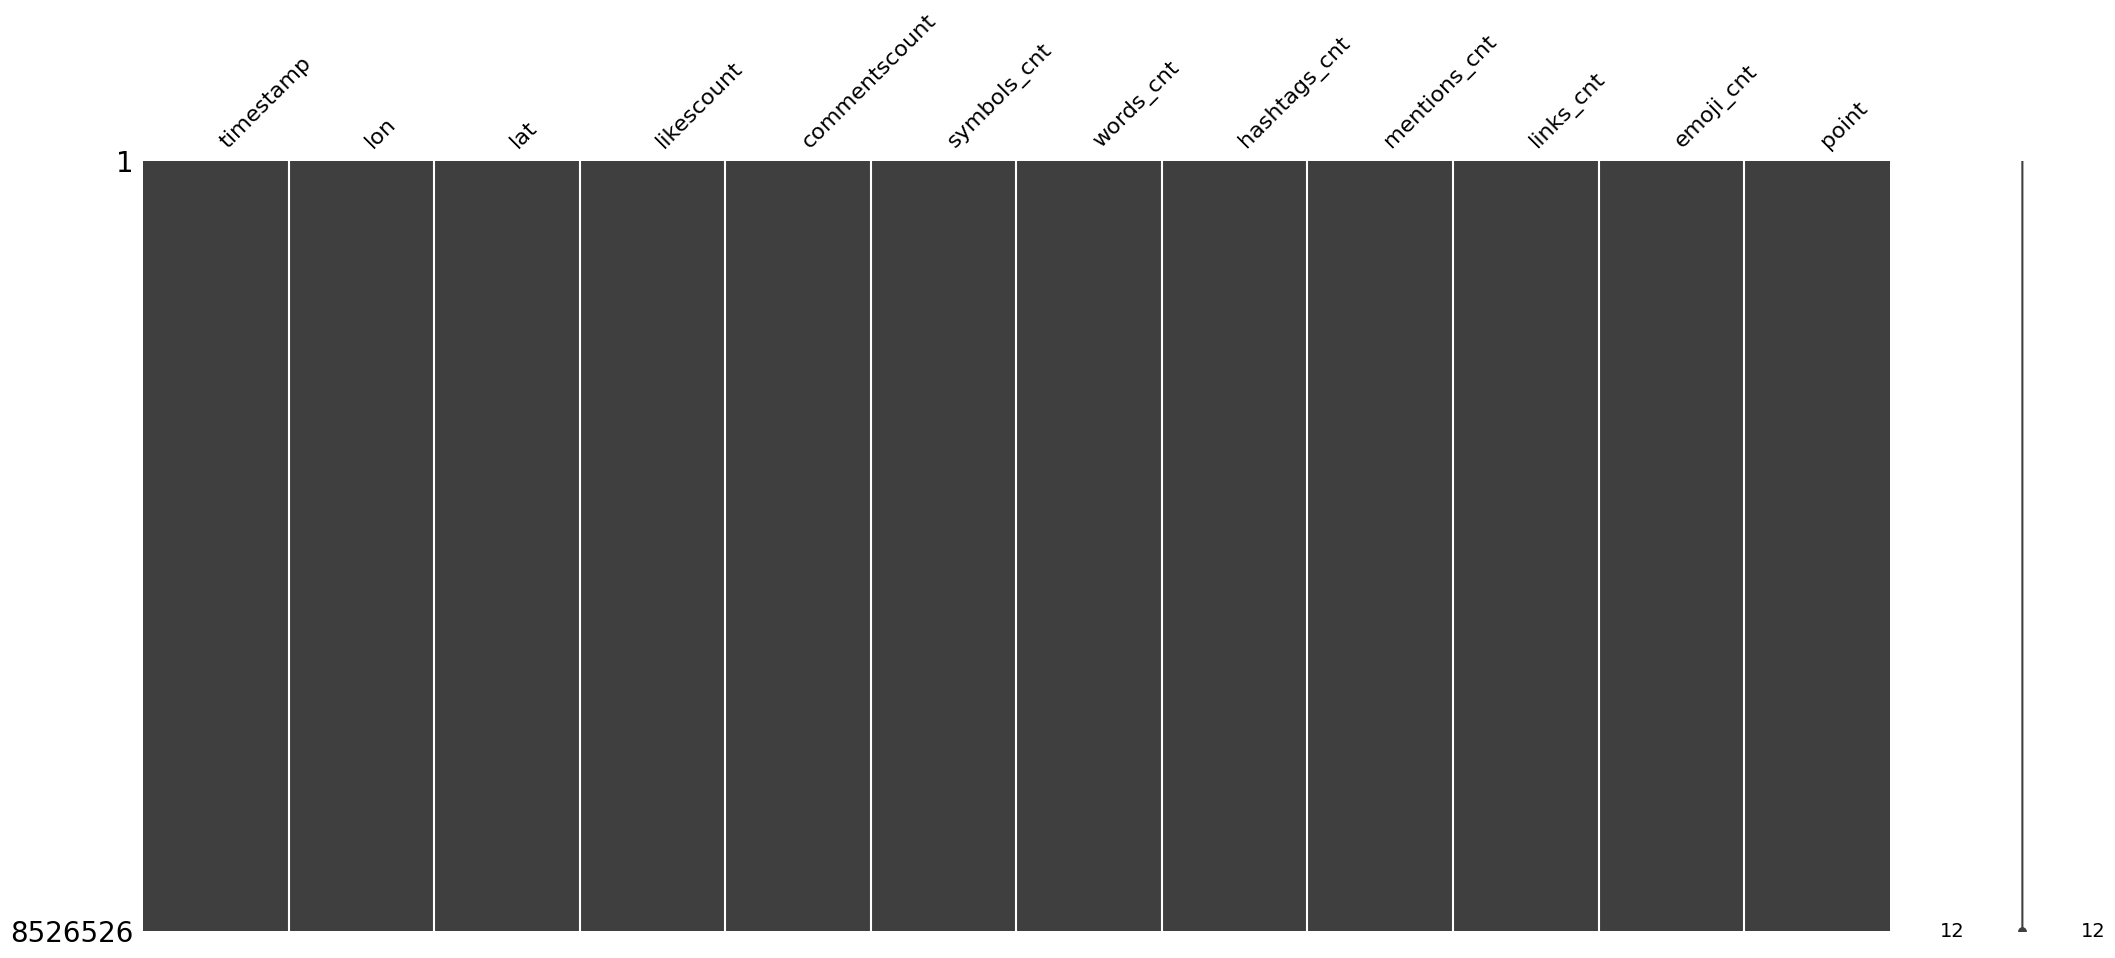

<Figure size 1500x500 with 0 Axes>

In [ ]:
''' It is the nullity matrix that allows us to see the distribution of data across all columns
    in the whole dataset. It also shows a sparkline (or, in some cases, a striped line) that
    emphasizes rows in a dataset with the highest and lowest nullity.
    From the below plot we can interpret our dataset if it has lots of missing values in it or not.
'''
msno.matrix(working_df)
plt.figure(figsize = (15,5))
plt.show()

In [ ]:
''' rather then getting numbers of nans/missing values from each fields, I am getting the ratio of them, i.e.
    I tried to analyse numerical summary of missing attributes. Because simple numerical summaries
    are effective at identifying problematic predictors and samples when the data become too
    large to visually inspect.
    print(f'Missing value ratios: \n{working_df.isnull().sum() / len(working_df) * 100}')
'''
def get_numerical_summary(working_df):
    missing_value_ratios = {}
    t_l = []
    p_l = []
    # print(f'Missing value numbers and their ratios:\n')
    for _ in working_df.columns:
        t = working_df[_].isnull().sum()
        t_l.append(t)
        p = (t/len(working_df)) * 100
        missing_value_ratios[_] = round(p, 3)
        p_l.append(round(p, 3))
        # print(f'{_}: {t} ({round(p, 3)}%)')
    missing_data = pd.DataFrame({'Number of missing values': t_l, 'Ratios in %': p_l}, index=working_df.columns)
    return missing_value_ratios, missing_data


missing_value_ratios, missing_data_train = get_numerical_summary(working_df)
missing_data_train

,Number of missing values,Ratios in %
timestamp,0,0.0
lon,0,0.0
lat,0,0.0
likescount,0,0.0
commentscount,0,0.0
symbols_cnt,0,0.0
words_cnt,0,0.0
hashtags_cnt,0,0.0
mentions_cnt,0,0.0
links_cnt,0,0.0


In [ ]:
missing_value_ratios, missing_data_test = get_numerical_summary(test_df)
missing_data_test

,Number of missing values,Ratios in %
hour,0,0.0
lat,0,0.0
lon,0,0.0
point,0,0.0
sum,0,0.0
error,0,0.0


In [ ]:
missing_value_ratios, missing_data_validation = get_numerical_summary(validation_df)
missing_data_validation

,Number of missing values,Ratios in %
hour,0,0.0
lat,0,0.0
lon,0,0.0
point,0,0.0
sum,0,0.0
error,0,0.0


It seems that we do not need to handle with missing values because all fields' percentage is zero.

 ### 2. Let's select the locations that belong to ['60.0393322852', '30.5360', '59.828', '30.142969'] coordinates and delete those that are not part of the that coordinates.

In [ ]:
coordinates = ['59.828', '60.0393322852', '30.142969', '30.5360']
print(coordinates)

['59.828', '60.0393322852', '30.142969', '30.5360']


In [ ]:
min_lat, max_lat, min_lon, max_lon = np.array(coordinates).astype(np.float32)

working_df = working_df[(min_lon <= working_df["lon"]) & (working_df["lon"] <= max_lon)]
working_df = working_df[(min_lat <= working_df["lat"]) & (working_df["lat"] <= max_lat)]

test_df = test_df[(min_lon <= test_df["lon"]) & (test_df["lon"] <= max_lon)]
test_df = test_df[(min_lat <= test_df["lat"]) & (test_df["lat"] <= max_lat)]

validation_df = validation_df[(min_lon <= validation_df["lon"]) & (validation_df["lon"] <= max_lon)]
validation_df = validation_df[(min_lat <= validation_df["lat"]) & (validation_df["lat"] <= max_lat)]

print(f'Dataset shapes:\n')
print(f'Train: {working_df.shape}')
print(f'Test: {test_df.shape}')
print(f'Validation: {validation_df.shape}')

Dataset shapes:

Train: (8389074, 12)
Test: (700, 6)
Validation: (686, 6)


In [ ]:
''' Dataset optimization process'''

working_df["sum"] = 1
working_df.rename(columns = {'timestamp':'hour'}, inplace = True)

working_df['datetime'] = pd.to_datetime(working_df['hour'], unit="s")
test_df['datetime'] = pd.to_datetime(test_df['hour'], unit="s")
validation_df['datetime'] = pd.to_datetime(validation_df['hour'], unit="s")

junky_fields = ['hour', 'likescount', 'commentscount', 'symbols_cnt', 'words_cnt', 'hashtags_cnt', 'mentions_cnt', 'links_cnt', 'emoji_cnt']
working_df.drop(junky_fields, axis=1, inplace=True)

junky_fields = ['hour']
test_df.drop(junky_fields, axis=1, inplace=True)
validation_df.drop(junky_fields, axis=1, inplace=True)


working_df = working_df.groupby(by=['datetime', 'point', 'lon', 'lat'], as_index=False).sum()


print(f'Dataset shapes:\n')
print(f'Train: {working_df.shape}')
print(f'Test: {test_df.shape}')
print(f'Validation: {validation_df.shape}')


Dataset shapes:

Train: (3587585, 5)
Test: (700, 6)
Validation: (686, 6)


In [ ]:
''' To reduce memory consumption, we need to vary the data types of the fields '''

c_l = ['lon', 'lat', 'sum']
for _ in c_l:
  working_df[_] = working_df[_].astype(np.float32)

c_l = ['lon', 'lat', 'sum', 'error']
for _ in c_l:
  test_df[_] = test_df[_].astype(np.float32)
  validation_df[_] = validation_df[_].astype(np.float32)

working_df.info()
print(f'\n')
test_df.info()
print(f'\n')
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3587585 entries, 0 to 3587584
Data columns (total 5 columns):
 #   Column    Dtype         
---  ------    -----         
 0   datetime  datetime64[ns]
 1   point     object        
 2   lon       float32       
 3   lat       float32       
 4   sum       float32       
dtypes: datetime64[ns](1), float32(3), object(1)
memory usage: 95.8+ MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 0 to 699
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   lat       700 non-null    float32       
 1   lon       700 non-null    float32       
 2   point     700 non-null    object        
 3   sum       700 non-null    float32       
 4   error     700 non-null    float32       
 5   datetime  700 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float32(4), object(1)
memory usage: 27.3+ KB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 686 entr

### 3. Preparation for Regression Procedure.

Here, we will try to extract the data from the datetime, i.e. extraction time properties.

In [ ]:
''' Reading whole dataset from refined files and loading the data and save it in a DataFrame
'''

df_l = [working_df, test_df, validation_df]
df_l[0].head(5)

,datetime,point,lon,lat,sum
0,2019-01-01,0101000020E610000002BF48199F3F3E4010C569574E02...,30.248522,60.018017,1.0
1,2019-01-01,0101000020E610000002BF48199F3F3E40586790FFD8EC...,30.248522,59.850372,1.0
2,2019-01-01,0101000020E61000000614FD60523D3E400086058A8CFB...,30.239538,59.965225,1.0
3,2019-01-01,0101000020E61000000614FD60523D3E4074DD5BB2DBED...,30.239538,59.858269,2.0
4,2019-01-01,0101000020E61000000614FD60523D3E40D800D455BF04...,30.239538,60.037090,1.0


In [ ]:
point_ids = df_l[0]["point"].unique().tolist()

for v in df_l:
    v["hour"] = v["datetime"].dt.hour
    v["day"] = v["datetime"].dt.day
    v["month"] = v["datetime"].dt.month
    v["year"] = v["datetime"].dt.year
    v["weekday"] = v["datetime"].dt.weekday
    v["weekend"] = v["datetime"].dt.weekday // 5
    v["point_id"] = v["point"].apply(lambda row: point_ids.index(row))
    v.drop(["point", "datetime"], axis=1, inplace=True)


In [ ]:
''' Data standardisation process

    To leverage the performance and accuracy of the model, the standardization process is applied. Here, all data points are standardized
    values. Consequently, they are all z-scores which make our data more interpretable and comparable since they have a mean of zero and
    a standard deviation of one.
'''

# for _ in df_l[0].columns:
#   mean = df_l[0][_].mean()
#   std  = df_l[0][_].std()
#   for row in df_l[0].itertuples():
#     df_l[0].at[row.Index, _ ] = (df_l[0].loc[row.Index, _ ]-mean)/std

# for _ in df_l[1].columns:
#   mean = df_l[1][_].mean()
#   std  = df_l[1][_].std()
#   for row in df_l[1].itertuples():
#     df_l[1].at[row.Index, _ ] = (df_l[1].loc[row.Index, _ ]-mean)/std

# for _ in df_l[2].columns:
#   mean = df_l[2][_].mean()
#   std  = df_l[2][_].std()
#   for row in df_l[2].itertuples():
#     df_l[2].at[row.Index, _ ] = (df_l[2].loc[row.Index, _ ]-mean)/std


' Data standardisation process\n\n    To leverage the performance and accuracy of the model, the standardization process is applied. Here, all data points are standardized\n    values. Consequently, they are all z-scores which make our data more interpretable and comparable since they have a mean of zero and\n    a standard deviation of one.\n'

In [ ]:
''' Finally, we are getting fully prepared dataframe as follow. '''
df_l[0].head(5)

,lon,lat,sum,hour,day,month,year,weekday,weekend,point_id
0,30.248522,60.018017,1.0,0,1,1,2019,1,0,0
1,30.248522,59.850372,1.0,0,1,1,2019,1,0,1
2,30.239538,59.965225,1.0,0,1,1,2019,1,0,2
3,30.239538,59.858269,2.0,0,1,1,2019,1,0,3
4,30.239538,60.037090,1.0,0,1,1,2019,1,0,4


In [ ]:
''' Finally, we are getting fully prepared dataframe as follow. '''
df_l[1].head(5)

,lat,lon,sum,error,hour,day,month,year,weekday,weekend,point_id
0,59.934864,30.331615,7.0,0.370265,10,26,2,2020,2,0,145
1,59.940487,30.329370,6.0,0.754735,11,17,2,2020,0,0,203
2,59.905598,30.297928,5.0,3.754735,16,12,2,2020,2,0,1395
3,59.921360,30.356319,16.0,4.088068,13,12,2,2020,2,0,187
4,59.939362,30.315895,10.0,2.088068,13,15,2,2020,5,1,101


In [ ]:
''' Finally, we are getting fully prepared dataframe as follow. '''
df_l[2].head(5)

,lat,lon,sum,error,hour,day,month,year,weekday,weekend,point_id
0,59.926987,30.318140,5.0,0.421402,9,23,2,2020,6,1,248
1,59.924736,30.241783,14.0,0.310291,19,20,2,2020,3,0,313
2,60.002300,30.295683,5.0,3.754735,15,9,2,2020,6,1,306
3,59.935989,30.324879,7.0,0.504735,17,17,2,2020,0,0,277
4,59.933739,30.306911,14.0,1.554735,5,27,2,2020,3,0,107


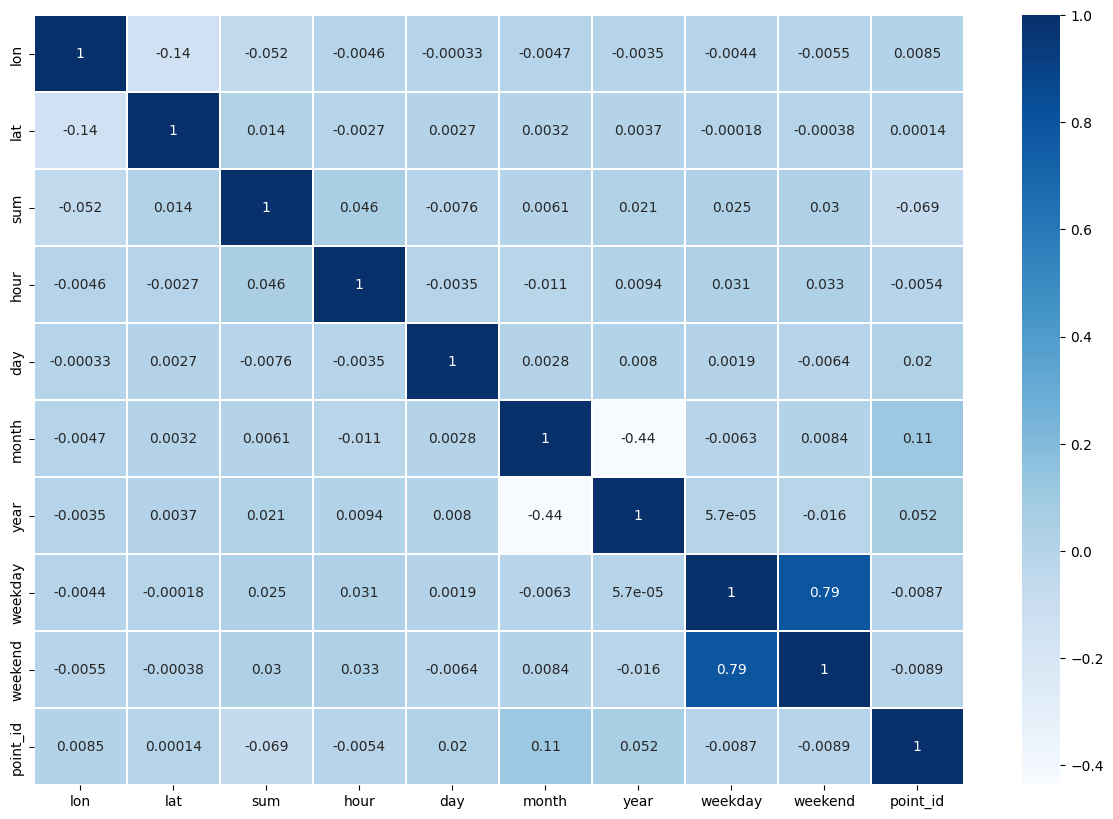

In [ ]:
''' Correlation heatmap measures nullity correlation between columns of the dataset. It shows how strongly the presence or
    absence of one feature affects the other.

    Nullity correlation ranges from(-1 to 1):

    *   -1 means if one column(attribute) is present, the other is almost certainly absent.
    *    0 means there is no dependence between the columns(attributes).
    *    1 means if one column(attributes) is present, the other is also certainly present.

    The heatmap is helpful for identifying data completeness correlations between attribute pairs, but it has the limited
    explanatory ability for broader relationships and no special support for really big datasets.
'''

figure, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.heatmap(df_l[0].corr(), cmap="Blues", annot=True, linewidths=0.25)
plt.show()


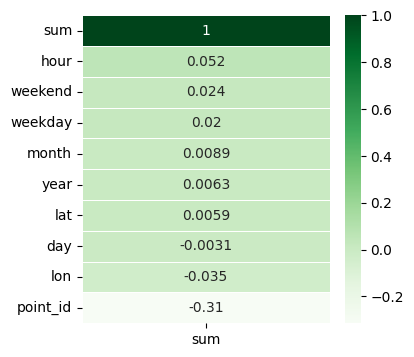

In [ ]:
''' Let's find correlations between the selected features and the target variable. '''
figure, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.heatmap(df_l[0].corr(method="spearman")[["sum"]].sort_values(by="sum", ascending=False), cmap="Greens", annot=True, linewidths=0.5)
plt.show()

### 4. Regression Procedure.

Here, we will try to implement Extreme Gradient boosting algorithm.

XGBoost is a complex model frequently used in the data science domain. It is tree-based model and display excellent performance in capturing complicated patterns within data. The XG boosting algorithm creates a sequential ensemble of tree models, all of which work to improve each other and determine the final output. This algorithm can be used to create the XGBoost classifier as well as the regressor. The XG Boosting algorithm uses advanced regularization techniques to suppress weights, prevent overfitting, and enhance its performance in real-world scenarios. On top of this, the implementation allows the algorithm to cache data and utilize multiple CPU cores for speedy processing. The enhanced performance and speed have made XGBoost one of the most popular machine-learning algorithms in recent years.

The XG boosting algorithm can be used for classification and regression. The XGBoost classifier is used for discrete outputs (classes), while the regressor predicts continuous values. Thus, due to its superior features and better real-world performance, engineers prefer XGBoost algorithm.  

In [ ]:
''' Finally, we are getting fully prepared dataframe as follow. '''
df_l[0].head(5)

,lon,lat,sum,hour,day,month,year,weekday,weekend,point_id
0,30.248522,60.018017,1.0,0,1,1,2019,1,0,0
1,30.248522,59.850372,1.0,0,1,1,2019,1,0,1
2,30.239538,59.965225,1.0,0,1,1,2019,1,0,2
3,30.239538,59.858269,2.0,0,1,1,2019,1,0,3
4,30.239538,60.037090,1.0,0,1,1,2019,1,0,4


In [ ]:
''' Splitting Data into Training and Test Sets
    The data we use is usually split into training data and test data. The training set contains a known output and the model learns
    on this data in order to be generalized to other data later on. We have the test dataset (or subset) in order to test our model’s
    prediction on this subset. Let us set 'sum' as the target variable.
'''
X_train = df_l[0].drop(['sum'], axis=1)
y_train = df_l[0][['sum']]

X_test = df_l[1].drop(['sum', 'error'], axis=1)
X_test = X_test.loc[:, X_train.columns]
y_test = df_l[1][['sum']]

X_valid = df_l[2].drop(['sum', 'error'], axis=1)
X_valid = X_valid.loc[:, X_train.columns]
y_valid = df_l[2][['sum']]

X_train, y_train = shuffle(X_train, y_train)

print(f'Dataset shapes:\n')
print(f'Train: {X_train.shape}')
print(f'Test: {X_test.shape}')
print(f'Validation: {X_valid.shape}')

Dataset shapes:

Train: (3587585, 9)
Test: (700, 9)
Validation: (686, 9)


### 4.a Metrics for testing model's performance

The **MSE**, **MAE**, **RMSE**, and **R-Squared** are mainly used metrics to evaluate the prediction error rates and model performance in regression analysis.


*   **MAE** (Mean absolute error) represents the difference between the original and predicted values extracted by averaged the absolute difference over the data set.
*   **MSE** (Mean Squared Error) represents the difference between the original and predicted values extracted by squared the average difference over the data set.

*   **RMSE** (Root Mean Squared Error) is the error rate by the square root of MSE.
*  **R-squared** (Coefficient of determination) represents the coefficient of how well the values fit compared to the original values. The value from 0 to 1 interpreted as percentages. The higher the value is, the better the model is.

In [ ]:
# here, we can create helper functions to append the metrics to a DataFrame containing the results
# Estimate the model accuracy by calculating R-squared and others statistics

results_df = pd.DataFrame()
columns = ["Model", "Cross Val Score", "MAE", "MSE", "RMSE", "R2"]

def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

def append_results(model_name, model, results_df, y_test, pred):
    results_append_df = pd.DataFrame(data=[[model_name, *evaluate(y_test, pred), cross_val_score(model, X_train, y_train, cv=10).mean()]], columns=columns)
    results_df = results_df.append(results_append_df, ignore_index = True)
    return results_df


In [ ]:
''' Linear regression is an algorithm which tries to learn the correlation between a dependent variable and one or more independent features. '''

reg = LinearRegression()
reg.fit(X_train,y_train)

predicted_values = reg.predict(X_test)
predicted_values_validation = reg.predict(X_valid)

results_df = append_results("Linear Regression (Test)",  LinearRegression(), results_df, y_test, predicted_values)
results_df = append_results("Linear Regression (Validation)",  LinearRegression(), results_df, y_valid, predicted_values_validation)

results_df


,Model,Cross Val Score,MAE,MSE,RMSE,R2
0,Linear Regression (Test),6.727551,86.309044,9.290266,-1.090270,0.011802
1,Linear Regression (Validation),6.881026,88.768862,9.421723,-1.122811,0.011802


In [ ]:
''' Implementing Extreme Gradient boosting algorithm. '''

reg = XGBRegressor(n_jobs=-1)
reg_stat = reg.fit(X_train, y_train)
reg_stat.get_params

predicted_values_test = reg_stat.predict(X_test)
predicted_values_validation = reg_stat.predict(X_valid)

results_df = append_results("XGBRegressor (Test)",  XGBRegressor(), results_df, y_test, predicted_values_test)
results_df = append_results("XGBRegressor (Validation)",  XGBRegressor(), results_df, y_valid, predicted_values_validation)

results_df

,Model,Cross Val Score,MAE,MSE,RMSE,R2
0,Linear Regression (Test),6.727551,86.309044,9.290266,-1.090270,0.011802
1,Linear Regression (Validation),6.881026,88.768862,9.421723,-1.122811,0.011802
2,XGBRegressor (Test),4.232666,40.188469,6.339437,0.026698,0.563980
3,XGBRegressor (Validation),4.420574,38.010445,6.165261,0.091022,0.563980


In [ ]:
''' Calculating total (Lab) metric on a validation dataset. '''

custom_loss = []
y_valid = y_valid['sum'].tolist()

''' The enumerate object yields pairs containing a count (from start, which defaults to zero) and
                                                 a value yielded by the iterable argument.
'''
for c, v in enumerate(predicted_values_validation):
    custom_loss.append(abs(v-y_valid[c])/v)

print(f'Validation loss for Lab (should not exceed 2.6): {np.array(custom_loss).mean():.5f}')

Validation loss for Lab (should not exceed 2.6): 1.16409


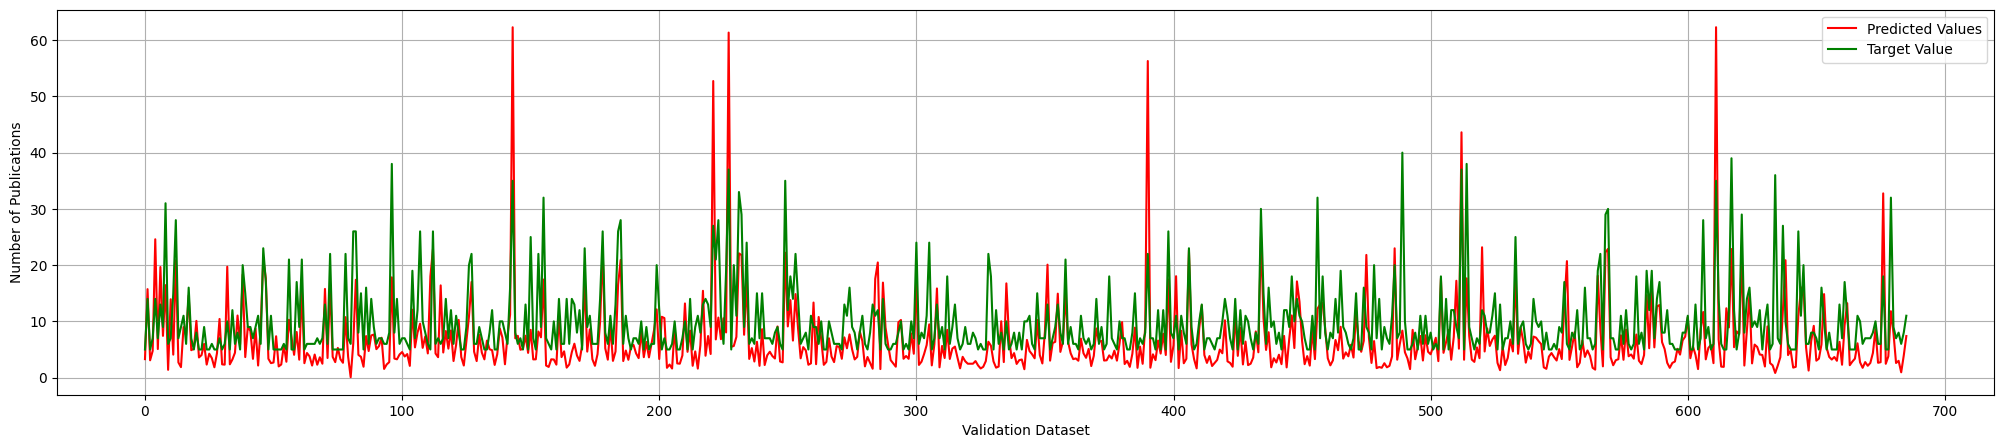

In [ ]:
''' Now, let us see how well the model predicts the number of publications on the validation dataset. '''
plt.figure(figsize=(25, 5))
plt.plot(predicted_values_validation, label='Predicted Values', color='red')
plt.plot(y_valid, label='Target Value', color='green')
plt.ylabel('Number of Publications')
plt.xlabel('Validation Dataset')
plt.grid(True)
plt.legend()
plt.show()


### 5. ML model interpretation

Interpretation of a machine learning model is the process wherein we try to understand the predictions of a machine learning model.

In [ ]:
''' Calculating the importance of features for the trained model on the validation dataset. We do this to know
    which features have the biggest impact on predictions by using a model, this concept is called feature importance.
    That gives us the weights associated to each feature, that can be seen as the contribution of each feature into prediction.
    Visualization of feature importance
'''

print(f'Visualisation of the weights associated to each feature:\n')
importance = PermutationImportance(reg_stat, random_state=42).fit(X_valid, y_valid)
eli5.show_weights(importance, feature_names=X_valid.columns.tolist())


Visualisation of the weights associated to each feature:



Weight,Feature
0.6424 ± 0.1343,point_id
0.4698 ± 0.1392,lat
0.3075 ± 0.0417,lon
0.2779 ± 0.0382,hour
0.0190 ± 0.0117,weekday
0 ± 0.0000,weekend
0 ± 0.0000,year
0 ± 0.0000,month
-0.0360 ± 0.0541,day


In [ ]:
''' Implementing Extreme Gradient boosting algorithm (tuned version).
    To improve the accuracy of the model, we try to use the parameters as below as a tuning
'''

reg = XGBRegressor(n_jobs=-1, n_estimators=300, max_leaves=30, max_depth=20)
reg_tuned = reg.fit(X_train, y_train)
reg_tuned.get_params

predicted_values_test = reg_tuned.predict(X_test)
predicted_values_validation = reg_tuned.predict(X_valid)

results_df = append_results("Tuned XGBRegressor (Test)",  XGBRegressor(), results_df, y_test, predicted_values_test)
results_df = append_results("Tuned XGBRegressor (Validation)",  XGBRegressor(), results_df, y_valid, predicted_values_validation)

results_df

,Model,Cross Val Score,MAE,MSE,RMSE,R2
0,Linear Regression (Test),6.727551,86.309044,9.290266,-1.090270,0.011802
1,Linear Regression (Validation),6.881026,88.768862,9.421723,-1.122811,0.011802
2,XGBRegressor (Test),4.232666,40.188469,6.339437,0.026698,0.563980
3,XGBRegressor (Validation),4.420574,38.010445,6.165261,0.091022,0.563980
4,Tuned XGBRegressor (Test),4.103253,38.586559,6.211808,0.065494,0.563980
5,Tuned XGBRegressor (Validation),4.233357,35.744033,5.978631,0.145220,0.563980


In [ ]:
''' Calculating total (Lab) metric on a validation dataset. '''

custom_loss = []
y_valid = df_l[2][['sum']]
y_valid = y_valid['sum'].tolist()

''' The enumerate object yields pairs containing a count (from start, which defaults to zero) and
                                                 a value yielded by the iterable argument.
'''
for c, v in enumerate(predicted_values_validation):
    custom_loss.append(abs(v-y_valid[c])/v)

print(f'Validation loss for Lab (should not exceed 2.6): {np.array(custom_loss).mean():.5f}')

Validation loss for Lab (should not exceed 2.6): 1.29432


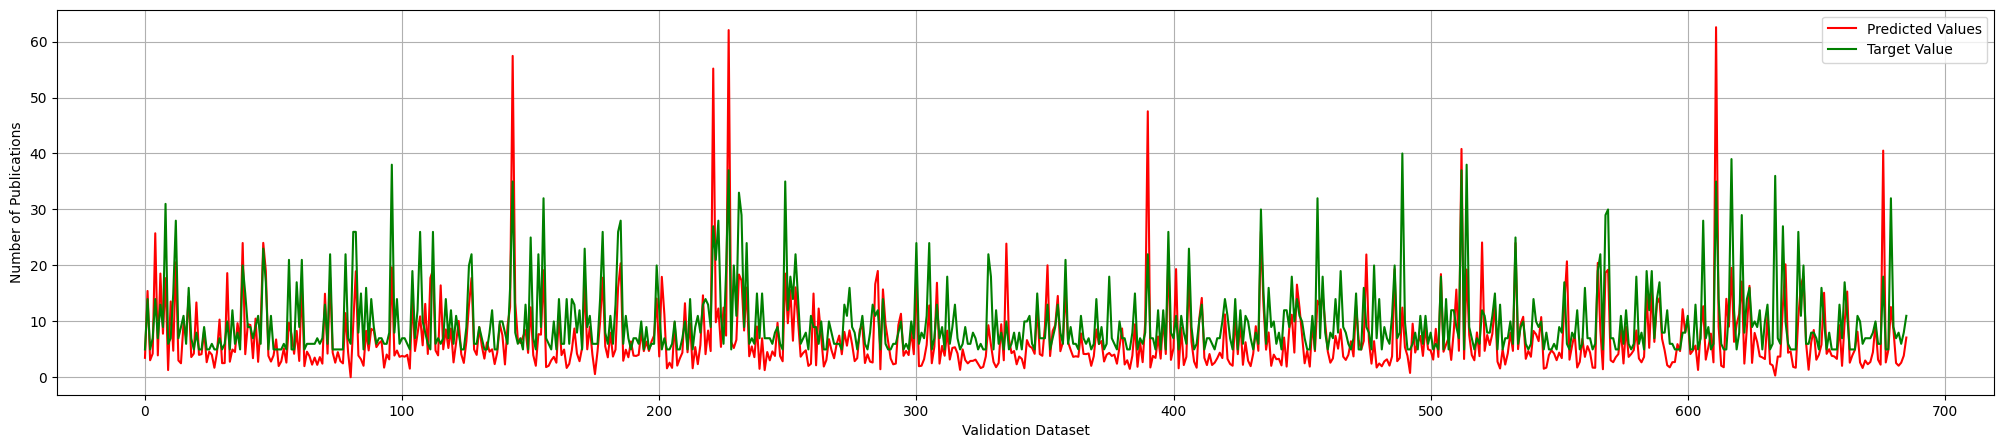

In [ ]:
''' Now, let us see how well the model predicts the number of publications on the validation dataset. '''
plt.figure(figsize=(25, 5))
plt.plot(predicted_values_validation, label='Predicted Values', color='red')
plt.plot(y_valid, label='Target Value', color='green')
plt.ylabel('Number of Publications')
plt.xlabel('Validation Dataset')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
''' Calculating the importance of features for the trained model on the validation dataset. We do this to know
    which features have the biggest impact on predictions by using a model, this concept is called feature importance.
    That gives us the weights associated to each feature, that can be seen as the contribution of each feature into prediction.
    Visualization of feature importance.
'''

print(f'Visualisation of the weights associated to each feature:\n')
importance = PermutationImportance(reg_tuned, random_state=42).fit(X_valid, y_valid)
eli5.show_weights(importance, feature_names=X_valid.columns.tolist())

Visualisation of the weights associated to each feature:



Weight,Feature
0.8553 ± 0.1549,point_id
0.3967 ± 0.0755,lat
0.2998 ± 0.0435,lon
0.2805 ± 0.0496,hour
0.0225 ± 0.0088,weekday
0 ± 0.0000,weekend
0 ± 0.0000,year
0 ± 0.0000,month
-0.0089 ± 0.0219,day


### **Conclusion**

We can conclude that Extreme Gradient boosting algorithm is indeed very effective among other models.
